# Kan Hücresi Alt Tipi Sınıflandırması: Finetune VGG16 modeli kullanılarak Transfer Öğrenme.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Verilerin Yüklenmesi

In [2]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (150,150)

In [3]:
def load_data():

    datasets = ['/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN','/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST' ]
    images = []
    labels = []

    # Eğitim ve test kümeleri arasında yineleme yapınız.
    for dataset in datasets:

        # Her veri kümesindeki klasörler arasında yineleme yapınız.
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # her bir görüntünün path alınız.
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # img dosyasını açın ve yeniden boyutlandırınız
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Görüntüyü ve ona karşılık gelen etiketi çıktıya ekleyeniz
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [4]:
images, labels = load_data()

100%|██████████| 623/623 [00:04<00:00, 136.56it/s]


In [5]:
images, labels = shuffle(images, labels, random_state=5)

# Verileri eğitim ve doğrulama kümelerine bölünmesi (%70 eğitim, %30 test)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.3)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

# Model oluşturma ve eğitimi

In [6]:
### Model numarası 3: Ayarlı VGG16 modeli. 

from keras.applications import VGG16

vgg16_model = VGG16(
    include_top = False,
    weights = 'imagenet', 
    input_tensor = None, 
    input_shape = (150,150,3), 
    pooling = None
)

# 3 tam bağlı katman eklendi, sırasıyla 256, 128 ve 64 birim
# Dropout ve Batch Normalization tam bağlı katmanlarda gerçekleştirildi.
# Burada VGG15 modelindeki son blokta eğitim verme seçeneği ("True") veya bu katman için imagenet ağırlıklarını kullanma seçeneği ("False")

vgg16_model.trainable = True

for layer in vgg16_model.layers:
  if 'block5' in layer.name:
    layer.trainable = False
  else:
    layer.trainable = False

input = Input(shape = (150,150,3))

layer = vgg16_model(inputs=input)
layer = Flatten()(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=256, activation='relu')(layer)
layer = Dropout(0.7)(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=128, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=64, activation='relu')(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=4,activation='softmax')(layer)

model3 = Model(inputs=input, outputs=layer)

model3.summary()

model3.compile(loss='sparse_categorical_crossentropy',
            optimizer= 'adam',
            metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

58892288/58889256 [==============================] - 2s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_______________________________________________________

Modelin kayıp ve doğrulama doğruluğunun her birinin yakınsayıp yakınsamayacağını görmek için, dönem sayısını 10-15'ten (Bölüm 1 ve 2'de önceki iki modelde kullandığım) 30'a çıkarmaya karar verdik. Gerçekten de öyle oldu ve bu platoları aşağıdaki grafiklerde görselleştirebilirsiniz.

In [7]:
history3 = model3.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 30, 
    validation_data = (val_images, val_labels), 
    callbacks=[learning_rate_reduction])

Epoch 1/30
273/273 [==============================] - 12s 46ms/step - loss: 1.4904 - accuracy: 0.3087 - val_loss: 1.1952 - val_accuracy: 0.5201
Epoch 2/30
273/273 [==============================] - 11s 42ms/step - loss: 1.2411 - accuracy: 0.4318 - val_loss: 0.9777 - val_accuracy: 0.5940
Epoch 3/30
273/273 [==============================] - 11s 42ms/step - loss: 1.0575 - accuracy: 0.5421 - val_loss: 0.7785 - val_accuracy: 0.6792
Epoch 4/30
273/273 [==============================] - 11s 42ms/step - loss: 0.9167 - accuracy: 0.6127 - val_loss: 0.6682 - val_accuracy: 0.7172
Epoch 5/30
273/273 [==============================] - 11s 42ms/step - loss: 0.7918 - accuracy: 0.6746 - val_loss: 0.5886 - val_accuracy: 0.7456
Epoch 6/30
273/273 [==============================] - 11s 42ms/step - loss: 0.7146 - accuracy: 0.7125 - val_loss: 0.5476 - val_accuracy: 0.7863
Epoch 7/30
273/273 [==============================] - 11s 42ms/step - loss: 0.6510 - accuracy: 0.7510 - val_loss: 0.5073 - val_accuracy:

In [12]:
# Doğruluk ve Kayıp grafik fonksiyonu oluşturma

def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(30)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Eğitim Doğruluğu')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Doğrulama Doğruluğu')
    ax[0].set_title('Eğitim ve Doğrulama Doğruluğu')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Kesinlik")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Eğitim Kaybı')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Doğrulama Kaybı')
    ax[1].set_title('Eğitim ve Doğrulama Kaybı')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Eğitim ve Doğrulama Kaybı")
    plt.show()

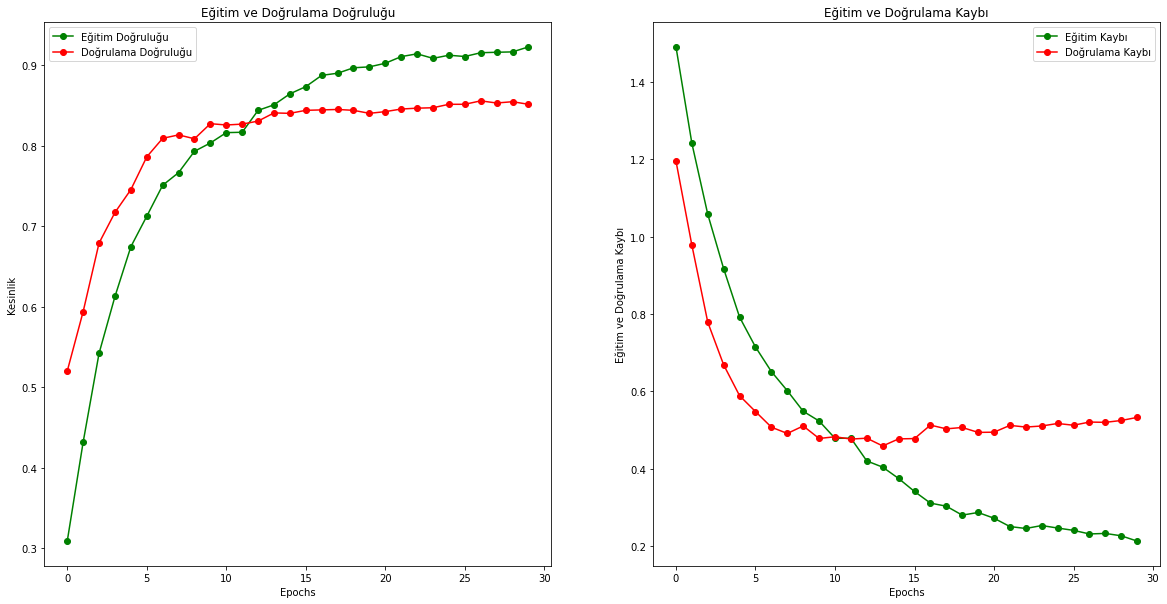

In [13]:
# Model 2 için Doğruluk ve Kayıp grafikleri

plot_accuracy_loss_chart(history3)

In [14]:
# Test verileri üzerinde modeli değerlendirme

results = model3.evaluate(test_images, test_labels)

print("Modelin kaybı - ", results[0])
print("Modelin doğruluğu - ", results[1]*100, "%")

59/59 [==============================] - 2s 33ms/step - loss: 0.5589 - accuracy: 0.8436
Modelin kaybı -  0.558904230594635
Modelin doğruluğu -  84.35993790626526 %


In [16]:
model3.save('Bloodcell_Classification_Model2_Finetuned_VGG16_30_epochs.h5')

In [17]:
# Test görüntüleri için tahminler oluşturması

predictions3 = model3.predict(test_images)
predictions3 = np.argmax(predictions3,axis=1)
predictions3[:15]

array([2, 3, 0, 1, 0, 3, 2, 3, 0, 3, 0, 0, 1, 3, 2])

In [18]:
from sklearn.metrics import classification_report

print(classification_report(
    test_labels, 
    predictions3, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.79      0.72      0.75       442
LYMPHOCYTE (Class 1)       0.87      0.92      0.90       469
  MONOCYTE (Class 2)       0.91      0.97      0.94       462
NEUTROPHIL (Class 3)       0.80      0.77      0.78       494

            accuracy                           0.84      1867
           macro avg       0.84      0.84      0.84      1867
        weighted avg       0.84      0.84      0.84      1867



In [20]:
# Karmaşıklık matrisi çizim fonksiyonu ve yürütme

def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)

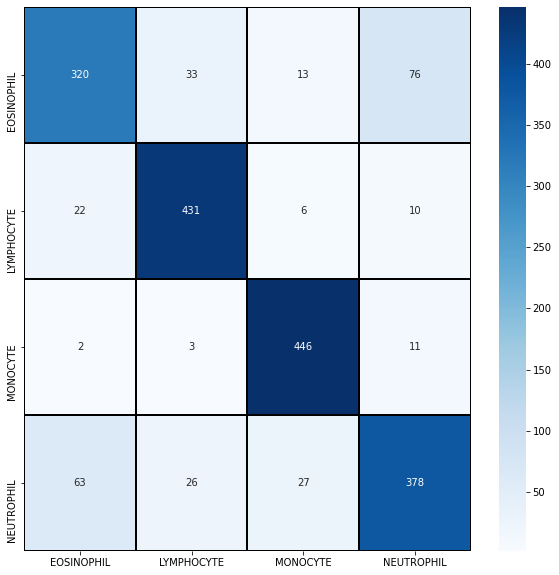

In [21]:
# Model 3 için grafik karışıklık matrisi

cm3 = confusion_matrix(test_labels, predictions3)
cm3 = pd.DataFrame(cm3, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
plot_confusion_matrix(cm3)

VGG16 modeli (%84,3), sıfırdan oluşturulan CNN'den (%91,6) ve Densenet201 modelinden (%91,2) önemli ölçüde daha kötü performans gösterdi. Nötrofiller ve Eozinofilleri sınıflandırmaya çalışırken Lenfositler ve Monositler üzerinde aynı yüksek performans eğilimlerini tekrar görüyoruz.

# Referanslar

Bazı kodlar şu şekilde uyarlandı: [Carlos Zuluaga](https://medium.com/@carlosz22/transfer-learning-using-keras-with-densenet-169-91679300f94a), [Vincee](https://www.kaggle.com/vincee/intel-image-classification-cnn-keras) ve [Abhinav Sagar](https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8)